In [1]:
# standard imports
%matplotlib inline
from basicimports import *

Last ran on /home/tboland1/Dropbox/Crozier Group User- Tara Boland/pymatgen from 2019-02-28 09:27:58.112141. 

home is /home/tboland1/Dropbox/TaraB/DFT/


In [2]:
# Use the ca2vac/ca_cf_0 lattice constant
wd = home + 'ca50pcV/'
ref_struct = home +'ca2vac/ca_cf_0/'
ref_lattice = (Poscar.from_file(filename=ref_struct+"POSCAR").structure)

# 1x1x1 50% configurations

Pickled data:
- Cation Configs: odst_spd_struct w/ comp 50% Ca @ GB
    - ../pkl/def_ca50vac_odst_cation_configs1x.pkl
- Cation Configs: matches
    - ../pkl/def_ca50pcV_cation_matches1x.pkl

In [4]:
# genreate cation configs - enter total # of Ca you want
Ca = 2
con_Ca = (Ca)/4
con_Ce = 1-con_Ca

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": 1}]
structure = Structure.from_spacegroup("Fm-3m", 
                                      Lattice.cubic(5.5),
                                      specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])
struct = structure.copy()

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation
odst = OrderDisorderedStructureTransformation()

odst_cation_configs = odst.apply_transformation(struct, return_ranked_list=1000000)
# Original pickling of 
#with open("../pkl/def_ca50vac_odst_cation_configs1x.pkl",'wb') as f:    
#    pickle.dump(odst_cation_configs,f)
with open("../pkl/def_ca50vac_odst_cation_configs1x.pkl", 'rb') as f:
    odst_cation_configs = pickle.load(f)

print('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_cation_configs),
          odst_cation_configs[0]['structure'].composition))

from pymatgen.analysis.structure_matcher import StructureMatcher
matcher = StructureMatcher()

# group the structures by their similarity
matches = matcher.group_structures(
    [d["structure"] for d in odst_cation_configs])
# Original pickling of 
#with open("../pkl/def_ca50pcV_cation_matches1x.pkl",'wb') as f:
#    pickle.dump(matches,f)
with open("../pkl/def_ca50pcV_cation_matches1x.pkl", 'rb') as f:
    matches = pickle.load(f)

# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
caArrange_groups = [matches[i][0] for i in range(len(matches))]

# the total number of unique structures found
unique_count = len(caArrange_groups)

# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]
print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

There is a total of 6 structure(s) created using the ODST.
The composition is Ca2+2 Ce4+2 O2-8.

The total number of unique structures found is 1.
The number frequency with which each structure occures is 
	 6.


In [5]:
# generate Ovac configs 
NN = [0, 3]  # 1NN shell
defect_type = 'Ca'  # defect type
# all the ca arrangements - there are currently 5
structs = caArrange_groups
rm_under_over_coord = [6, 8]

# the function
'''
Need to find the charge neutrality portion of this code on line 58
'''
from pymatgen.transformations.site_transformations import \
PartialRemoveSitesTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.analysis.local_env import CrystalNN

cNN = CrystalNN(cation_anion=True, distance_cutoffs=(NN))
matcher = StructureMatcher()

# {config_structs_#: [all possible defect sub-structure locations]}
config_Struct_Substruct_dict = {}

counter = 0
for tmp_struct in structs:
    defect_sites = [
        tmp_struct[defect_site] for defect_site in [
            tmp_struct.index(site) for site in tmp_struct
            if str(site.specie.element) == defect_type
        ]
    ]

    nn_data = [
        cNN.get_nn_data(structure=tmp_struct, n=tmp_struct.index(defect_site))
        for defect_site in defect_sites
    ]
    nn_site_index = [
        each_site['site_index'] for each_defect in nn_data
        for each_site in each_defect[0]
    ]
    prst = PartialRemoveSitesTransformation(
        [nn_site_index], [len(nn_data) / len(nn_site_index)])
    prst_structs = [
        each_element['structure']
        for each_element in prst.apply_transformation(
            structure=tmp_struct, return_ranked_list=10000)
    ]

    matches = matcher.group_structures(prst_structs)
    sub_structs = [matches[i][0] for i in range(len(matches))]
    unique_count = len(sub_structs)
    print((
        "The total number unique sub-structures found is {}.\n"
        .format(unique_count)))

    rm_list = []
    for struct in sub_structs:
        concen_dict = struct.composition.get_el_amt_dict()
        if concen_dict['O'] != (
                concen_dict['Ce'] + concen_dict['Ca']) * 2 - concen_dict['Ca']:
            print('removing structure due to wrong composition')
            sub_structs.remove(struct)
            continue
        defect_sites = [
            struct[defect_site] for defect_site in [
                struct.index(site) for site in struct
                if str(site.specie.element) == defect_type
            ]
        ]
        nn_data = [
            cNN.get_nn_data(structure=struct, n=struct.index(defect_site))
            for defect_site in defect_sites
        ]
        site_coord = [len(nn_data[i][0]) for i in range(len(nn_data))]
        if set(site_coord).issubset(rm_under_over_coord) == True:
            print('removing structure for invalid under/over coord')
            rm_list.append(sub_structs.index(struct))

    rm_list.reverse()
    for index in rm_list:
        sub_structs.pop(index)
    config_Struct_Substruct_dict['config_structs_' + str(counter)] = sub_structs
    counter += 1

The total number unique sub-structures found is 6.

removing structure due to wrong composition
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord


In [6]:
# # of vacancy containing structures per unique Ca arrangement (SM)
for key in config_Struct_Substruct_dict.keys():
    # collect the data for how many configuration for each Ca arrangement
    print(key, len(config_Struct_Substruct_dict[key]))
    struct = config_Struct_Substruct_dict[key]
    matches = matcher.group_structures(struct)
    # grouping of all structures by structural uniquiness found
    groups = [matches[i][0] for i in range(len(matches))]
    # the total number of unique structures found
    unique_count = len(groups)
    print(unique_count)

config_structs_0 1
1


### Create Simulations
Sync Command

    rsync -azPn ca50pcV/ tboland1@agave.asu.edu:/scratch/tboland1/ca50pcV/

    rsync -azPn --include='KPOINTS' --include='INCAR' --include='*/' --exclude='*' ca50pcV/ tboland1@agave.asu.edu:/scratch/tboland1/ca50pcV/
    
    rsync -azPn --include='INCAR' --include='*/' --exclude='*' ca50pcV/ tboland1@agave.asu.edu:/scratch/tboland1/ca50pcV/
    
Sync Back Command  

    rsync -azPn --exclude='WAVECAR*' --include='*' tboland1@agave.asu.edu:/scratch/tboland1/ca50pcV/ ca50pcV/

In [9]:
# initial relax (ran)
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    try: 
        os.makedirs(wd+'ca_cf_'+key.split('_')[2])
    except:
        path = path
    # create the structure
    struct = config_Struct_Substruct_dict[key][0]
    struct.remove_oxidation_states()
    struct.to(filename = path +'POSCAR_'+key.split('_')[2], fmt = 'POSCAR')
    
    # create INCAR (deleted kpar and npar)
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System'] = "50% Ca initial relax"+key
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['EDIFFG'] = -0.01
    relax_init_incar['EDIFF']  = 0.1E-04
    relax_init_incar['NPAR']   = 1
    relax_init_incar['KPAR']   = 1
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL']  = ul
    relax_init_incar['LDAUU']  = uu
    relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)    
    relax_init_incar.write_file(path+'INCAR')
    
    # create KPOINTS
    kp_file = Kpoints.automatic_density(structure=struct,kppa=50)
    kp_file.write_file(path+'KPOINTS')
    
    # create POTCAR
    potcar = Potcar(symbols=[i.replace('Ca','Ca_sv')
                     for i in struct.symbol_set],
                functional="PBE")
    potcar.write_file(path+'POTCAR')

# slurm for each calc
for key in config_Struct_Substruct_dict.keys():
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    with open(path + "parallel.sh", "w") as f:
        f.write(
            "#!/bin/bash\n"
            "#SBATCH -J 50%Ca_cf" + key.split('_')[2] + '\n'
            "#SBATCH -t 0-02:00\n"
            "#SBATCH -n 28\n"
            "#SBATCH -q aggressive \n"
            "#SBATCH --mem-per-cpu=4000\n"
            "#SBATCH --exclusive\n"
            "#SBATCH -o error.%j.out\n"
            "#SBATCH --mail-user=tboland1@asu.edu\n"
            "#SBATCH --mail-type=end\n"
            '\n'
            "module purge\n"
            "cd /scratch/tboland1/ca50pcV/"+'ca_cf_'+key.split('_')[2] + '\n'
            '\n'
            "module load intel/2018x\n"
            "module load vasp/5.4.4-elpa\n"
            'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"'
            + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP=slurm " + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP_EXEC=srun" + '\n'
            '\n'
            '\n'
            "mpiexec.hydra vasp_gam")

In [10]:
# high kp (ran) 
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    struct = config_Struct_Substruct_dict[key][0]
    
    relax_init_incar['System'] = "50% Ca vac high kp relax"+key
    relax_init_incar['NPAR']   = 1
    relax_init_incar['KPAR']   = 4
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['EDIFFG'] = -0.01
    relax_init_incar['EDIFF']  = 0.1E-04
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL']  = ul
    relax_init_incar['LDAUU']  = uu
    relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
    
    relax_init_incar.write_file(path+'INCAR')
    
    # create KPOINTS
    kp_file = Kpoints.automatic_density(
        structure=struct,kppa=800)
    kp_file.write_file(path+'KPOINTS')

In [11]:
# spE (ran)
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    struct = config_Struct_Substruct_dict[key][0]
    # create spE INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    ## edit
    relax_init_incar['System']  = "50% Ca 2 vac spin final E"
    relax_init_incar['ENCUT']   = 400
    relax_init_incar['ISIF']    = 2
    relax_init_incar['NSW']     = 0
    relax_init_incar['IBRION']  = -1
    relax_init_incar['ISPIN']   = 2
    relax_init_incar['EDIFF']   = 0.1E-04
    relax_init_incar['NPAR']    = 1
    relax_init_incar['KPAR']    = 4
    
    ul = [-1]*len(struct.symbol_set)
    uu = [0]*len(struct.symbol_set)
    counter = 0
    for element in list(struct.symbol_set):
        if element == 'Ce':
            ul[counter] = 3    
            uu[counter] = 5 
        counter += 1
    relax_init_incar['LDAUL']  = ul
    relax_init_incar['LDAUU']  = uu
    relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)        
    
    relax_init_incar.write_file(path+'INCAR')

## Analysis for 1x1x1 50% config Relaxation

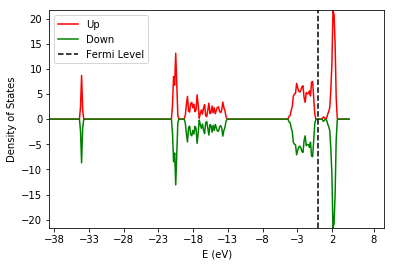

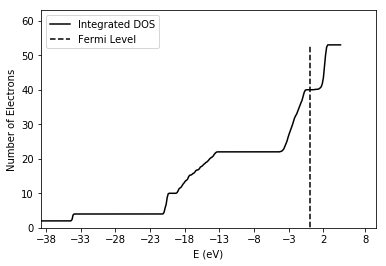

In [12]:
# plot dos 
for key in config_Struct_Substruct_dict.keys():
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    plot_density_of_states(path+'spE/')

In [15]:
# gather the energy & check the volume change on the final relaxation
for key in config_Struct_Substruct_dict.keys():
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    E_vac = Oszicar(filename=path + "spE/OSZICAR")
    print("The final energy is {:0.2f}".format(E_vac.final_energy))

# check the volume change on the final relaxation
RlxVolume_init =Poscar.from_file(
    wd+'ca_cf_0/relax-v1.1/POSCAR').structure.volume
RlxVolume_final=Poscar.from_file(
    wd+'ca_cf_0/relax-v1.1/CONTCAR').structure.volume
print('The percent volume change in final relax is {:0.2f}%.'.format(
    (1-RlxVolume_init/RlxVolume_final)*100))
print('The composition is {}'.format(Poscar.from_file(
    wd+'ca_cf_0/spE/POSCAR').structure.composition))

The final energy is -71.14
The percent volume change in final relax is 0.09%.
The composition is Ca2 Ce2 O6


In [ ]:
# plot structures
for key in config_Struct_Substruct_dict.keys():
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    show_struct_ase(Poscar.from_file(path+'POSCAR').structure)
    gvl(Poscar.from_file(path+'POSCAR').structure)

# 2x1x1 Unit Cell
This uses enumerate structure transformation.

Pickled

- cation configs: odst_cation_configs
    - ../pkl/def_ca50pcVac_est_cation_configs2x1x1.pkl
- cation configs unique: matches
    - ../pkl/def_ca50pcVac_cation_matches2x1x1.pkl
- cation + anion configs unique: config_Struct_Substruct_dict
    - ../pkl/def_ca50pcVac_confStructSubStructdict_2x1x1.pkl

In [4]:
# change just Ca ( enter total # of Ca you want)
Ca = 4
con_Ca = (Ca)/8
con_Ce = 1-con_Ca

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": 1}]
structure = Structure.from_spacegroup("Fm-3m", 
                                      Lattice.cubic(5.5),
                                      specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])
struct = structure.copy()
struct.make_supercell([2,1,1])

'''# load the transformer
from pymatgen.transformations.advanced_transformations import \
EnumerateStructureTransformation
est = EnumerateStructureTransformation()
odst_cation_configs = est.apply_transformation(struct, 
                                                return_ranked_list=1000000)
# Original pickling of 
with open("../pkl/def_ca50pcVac_est_cation_configs2x1x1.pkl",'wb') as f:#    
    pickle.dump(odst_cation_configs,f)'''
with open("../pkl/def_ca50pcVac_est_cation_configs2x1x1.pkl", 'rb') as f:
    odst_cation_configs = pickle.load(f)

print('There is a total of {} structure(s) created using the EST.\n'
      'The composition is {}.\n'.format(
          len(odst_cation_configs),
          odst_cation_configs[0]['structure'].composition))

There is a total of 8 structure(s) created using the EST.
The composition is Ca2+4 Ce4+4 O2-16.



In [5]:
# create unique cation configs
'''from pymatgen.analysis.structure_matcher import StructureMatcher
matcher = StructureMatcher()
# group the structures by their similarity 
matches = matcher.group_structures(
    [d["structure"] for d in odst_cation_configs])
# Original pickling of 
with open("../pkl/def_ca50pcVac_cation_matches2x1x1.pkl",'wb') as f:
    pickle.dump(matches,f)'''
with open("../pkl/def_ca50pcVac_cation_matches2x1x1.pkl", 'rb') as f:
    matches = pickle.load(f)

# collect # of groups, number frequency for each struct & disp data
# the grouping of all structures by structural uniquiness found
caArrange_groups = [matches[i][0] for i in range(len(matches))]

# the total number of unique structures found
unique_count = len(caArrange_groups)

# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]
print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

The total number of unique structures found is 7.
The number frequency with which each structure occures is 
	 1 1 2 1 1 1 1.


In [6]:
# generate O_vac configs 
'''NN = [0, 3]  # 1NN shell
defect_type = 'Ca'  # defect type
# all the ca arrangements - there are currently 5
structs = caArrange_groups
rm_under_over_coord = [6, 8]

# the function

# Need to find the charge neutrality portion of this code on line 58

from pymatgen.transformations.site_transformations import \
PartialRemoveSitesTransformation
from pymatgen.analysis.local_env import CrystalNN
cNN = CrystalNN(cation_anion=True, distance_cutoffs=(NN))

# {config_structs_#: [all possible defect sub-structure locations]}
config_Struct_Substruct_dict = {}

counter = 0
for tmp_struct in structs:
    defect_sites = [
        tmp_struct[defect_site] for defect_site in [
            tmp_struct.index(site) for site in tmp_struct
            if str(site.specie.element) == defect_type
        ]
    ]

    nn_data = [
        cNN.get_nn_data(structure=tmp_struct, n=tmp_struct.index(defect_site))
        for defect_site in defect_sites
    ]
    nn_site_index = [
        each_site['site_index'] for each_defect in nn_data
        for each_site in each_defect[0]
    ]
    prst = PartialRemoveSitesTransformation(
        [nn_site_index], [len(nn_data) / len(nn_site_index)])
    prst_structs = [
        each_element['structure']
        for each_element in prst.apply_transformation(
            structure=tmp_struct, return_ranked_list=10000)
    ]

    matches = matcher.group_structures(prst_structs)
    sub_structs = [matches[i][0] for i in range(len(matches))]
    unique_count = len(sub_structs)
    print((
        "The total number unique sub-structures found is {}.\n"
        .format(unique_count)))

    rm_list = []
    for struct in sub_structs:
        concen_dict = struct.composition.get_el_amt_dict()
        if concen_dict['O'] != (
                concen_dict['Ce'] + concen_dict['Ca']) * 2 - concen_dict['Ca']:
            sub_structs.remove(struct)
            continue
        defect_sites = [
            struct[defect_site] for defect_site in [
                struct.index(site) for site in struct
                if str(site.specie.element) == defect_type
            ]
        ]
        nn_data = [
            cNN.get_nn_data(structure=struct, n=struct.index(defect_site))
            for defect_site in defect_sites
        ]
        site_coord = [len(nn_data[i][0]) for i in range(len(nn_data))]
        if set(site_coord).issubset(rm_under_over_coord) == True:
            print('removing structure for invalid under/over coord')
            rm_list.append(sub_structs.index(struct))

    rm_list.reverse()
    for index in rm_list:
        sub_structs.pop(index)
    config_Struct_Substruct_dict['config_structs_' + str(counter)] = sub_structs
    counter += 1
# Original pickling of 
with open("../pkl/def_ca50pcVac_confStructSubStructdict_2x1x1.pkl",'wb') as f:
    pickle.dump(config_Struct_Substruct_dict,f)'''
# load Pickled var to save time
with open("../pkl/def_ca50pcVac_confStructSubStructdict_2x1x1.pkl", 'rb') as f:
    config_Struct_Substruct_dict = pickle.load(f)

    
# print keys,# of vacancy containing structures per unique Ca arrangement, S.M. results 
for key in config_Struct_Substruct_dict.keys():
    # collect the data for how many configuration for each Ca arrangement
    print(key, len(config_Struct_Substruct_dict[key]))
    struct = config_Struct_Substruct_dict[key]
    matches = matcher.group_structures(struct)
    # grouping of all structures by structural uniquiness found
    groups = [matches[i][0] for i in range(len(matches))]
    # the total number of unique structures found
    unique_count = len(groups)
    print('The composotion is {}.'.format(struct[0].composition))
    print(unique_count)

The total number unique sub-structures found is 118.

removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid und

removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/ove

removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
removing structure for invalid under/over coord
config_structs_0 72
The composotion is Ca2+4 Ce4+4 O2-14.
72
config_structs_1 119
The composotion is Ca2+4 Ce4+4 O2-14.
119
config_structs_2 73
The composotion is Ca2+4 Ce4+4 O2-14.
73
config_structs_3 422
The composotion is Ca2+4 Ce4+4 O2-14.
422
config_structs_4 132
The composotion is Ca2+4 Ce4+4 O2-14.
132
config_structs_5 132
The composotion is Ca2+4 Ce4+4 O2-14.
132
config_structs_6 48
The composotion is Ca2+4 Ce4+4 O2-14.
48


# 2x2x1 Configs
Enumerate Structure Transformation was used.
I will not be finding vacancy configuration for this... The above cell shows far too many structures to justify repeating that step. 

Pickled
- cation configs: odst_cation_configs
    - ../pkl/def_ca50pcVac_odst_cation_configs2x2x1.pkl
- cation configs: matches
    - ../pkl/def_ca50pcVac_cation_matches2x2x1.pkl

In [8]:
# enter total # of Ca you want -- create structure set
Ca = 8
con_Ca = (Ca)/16
con_Ce = 1-con_Ca

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": 1}]
structure = Structure.from_spacegroup("Fm-3m", 
                                      Lattice.cubic(5.5),
                                      specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])
struct = structure.copy()
struct.make_supercell([2,2,1])

'''# load the transformer
from pymatgen.transformations.advanced_transformations import \
EnumerateStructureTransformation
est = EnumerateStructureTransformation()
odst_cation_configs = est.apply_transformation(struct, 
                                                return_ranked_list=1000000)
# Original pickling of 
with open("../pkl/def_ca50pcVac_odst_cation_configs2x2x1.pkl",'wb') as f:#    
    pickle.dump(odst_cation_configs,f)'''
with open("../pkl/def_ca50pcVac_odst_cation_configs2x2x1.pkl", 'rb') as f:
    odst_cation_configs = pickle.load(f)

print('There is a total of {} structure(s) created using the EST.\n'
      'The composition is {}.\n'.format(
          len(odst_cation_configs),
          odst_cation_configs[0]['structure'].composition))

There is a total of 153 structure(s) created using the EST.
The composition is Ca2+8 Ce4+8 O2-32.



In [15]:
# create unique cation configs
'''#from pymatgen.analysis.structure_matcher import StructureMatcher
matcher = StructureMatcher()
# group the structures by their similarity 
matches = matcher.group_structures(
    [d["structure"] for d in odst_cation_configs])
# Original pickling of 
with open("../pkl/def_ca50pcVac_cation_matches2x2x1.pkl",'wb') as f:
    pickle.dump(matches,f)
'''
with open("../pkl/def_ca50pcVac_cation_matches2x2x1.pkl", 'rb') as f:
    matches = pickle.load(f)

# pull out only 1 struct from the list of many structures found
caArrange_groups = [matches[i][0] for i in range(len(matches))]

# the total number of unique structures found
unique_count = len(caArrange_groups)

# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]
print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

The total number of unique structures found is 151.
The number frequency with which each structure occures is 
	 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.


# 2x2x2 50% Configs
Too many configurations before filtering, can't do.

In [3]:
# change just Ca ( enter total # of Ca you want)
Ca = 13
con_Ca = (Ca)/32
con_Ce = 1-con_Ca
'''
specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": 1}]
structure = Structure.from_spacegroup("Fm-3m",Lattice.cubic(5.5) , specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

struct = structure.copy()
struct.make_supercell([2,2,2])

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation
odst = OrderDisorderedStructureTransformation()

odst_cation_configs = odst.apply_transformation(struct, return_ranked_list=1000000)
# Original pickling
with open("../pkl/def_ca13vac_odst_cation_configs.pkl",'wb') as f:   
    pickle.dump(odst_cation_configs,f)
with open("../pkl/def_ca13vac_odst_cation_configs.pkl", 'rb') as f:
     odst_cation_configs = pickle.load(f)

print('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_cation_configs),
          odst_cation_configs[0]['structure'].composition))

# remove duplicates
from pymatgen.analysis.structure_matcher import StructureMatcher
matcher = StructureMatcher()

# group the structures by their similarity
matches = matcher.group_structures(
    [d["structure"] for d in odst_cation_configs])
# Original pickling of 
with open("../pkl/def_ca13vac_cation_matches.pkl",'wb') as f:
    pickle.dump(matches,f)
with open("../pkl/def_ca13vac_cation_matches.pkl", 'rb') as f:
    matches = pickle.load(f)

# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
caArrange_groups = [matches[i][0] for i in range(len(matches))]

# the total number of unique structures found
unique_count = len(caArrange_groups)

# the frequency with which each unique structure occurres
num_freq =  [len(matches[i]) for i in range(len(matches))]
# Original pickling
with open("../pkl/def_ca13vac_num_freq.pkl",'wb') as f:
    pickle.dump(num_freq,f)
# load Pickled var to save time
with open("../pkl/def_ca13vac_num_freq.pkl",'rb') as f:
    num_freq = pickle.load(f)
print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

for struct,num in zip(caArrange_groups,num_freq):
    struct.modify_lattice(ref_lattice)'''
print()